In [4]:
#@title Imports
!pip install git+https://gitlab.com/neu-autonomy/gym-neu-racing.git

import gymnasium
import numpy as np
import gym_neu_racing
from gymnasium import spaces
from gym_neu_racing.envs.wrappers import StateFeedbackWrapper
import matplotlib.pyplot as plt
from typing import Callable
import matplotlib.cm as cmx
import matplotlib.colors as colors
import cvxpy as cp

  Cloning https://gitlab.com/neu-autonomy/gym-neu-racing.git to /tmp/pip-req-build-r_kyxsxh
  Running command git clone --filter=blob:none --quiet https://gitlab.com/neu-autonomy/gym-neu-racing.git /tmp/pip-req-build-r_kyxsxh
  Resolved https://gitlab.com/neu-autonomy/gym-neu-racing.git to commit 60f6a0e80b5ae6dd14fb13a837c252d0d88fe571
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 24.0 MB/s eta 0:00:00
  Created wheel for gym-neu-racing: filename=gym_neu_racing-0.0.1-py3-none-any.whl size=65580 sha256=ceb1c81948e2837c883cd3d8782da00a13c060d356aed0bc1c808ec2399596cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-5sz2oeaz/wheels/2b/40/20/13d3d44e20167f192ae2e89c0c279882d6064e6d226cc3efaa
Successfully built gym-neu-racing


In [28]:
#@title Motion Models

class MotionModel:
    """Abstract class for modeling the motion of a 2D mobile robot."""

    def __init__(self):
        pass

    def step(self, current_state, action, dt=0.1):
        """Move 1 timestep forward w/ kinematic model, x_{t+1} = f(x_t, u_t)"""
        raise NotImplementedError

class Unicycle(MotionModel):
    """Discrete-time unicycle kinematic model for 2D robot simulator."""

    def __init__(self, v_min=0, v_max=1, w_min=-2 * np.pi, w_max=2 * np.pi):
        self.action_space = spaces.Box(
            np.array([v_min, w_min]),
            np.array([v_max, w_max]),
            shape=(2,),
            dtype=float,
        )
        super().__init__()

    def step(
        self, current_state: np.ndarray, action: np.ndarray, dt: float = 0.1
    ) -> np.ndarray:
        """Move 1 timestep forward w/ kinematic model, x_{t+1} = f(x_t, u_t)"""
        # current_state = np.array([x, y, theta])
        # action = np.array([vx, vw])

        # clip the action to be within the control limits
        clipped_action = np.clip(
            action, self.action_space.low, self.action_space.high
        )

        current_state = current_state.reshape((-1, 3))
        clipped_action = clipped_action.reshape((-1, 2))
        next_state = np.empty_like(current_state)

        next_state[:, 0] = current_state[:, 0] + dt * clipped_action[
            :, 0
        ] * np.cos(current_state[:, 2])
        next_state[:, 1] = current_state[:, 1] + dt * clipped_action[
            :, 0
        ] * np.sin(current_state[:, 2])
        next_state[:, 2] = current_state[:, 2] + dt * clipped_action[:, 1]

        next_state = next_state.squeeze()

        return next_state

class NoisyUnicycle(Unicycle):
  """Same as Unicycle but add process noise at each step."""
  def __init__(self,
               process_noise_limits=np.array([0.02, 0.02, 0.1]) * 2,
               v_min=0, v_max=1, w_min=-2*np.pi, w_max=2*np.pi):
    self.process_noise_limits = process_noise_limits
    super().__init__(v_min=v_min, v_max=v_max, w_min=w_min, w_max=w_max)

  def step(
        self, current_state: np.ndarray, action: np.ndarray, dt: float = 0.1
    ) -> np.ndarray:
        """Move 1 timestep forward w/ kinematic model, x_{t+1} = f(x_t, u_t)"""
        # current_state = np.array([x, y, theta])
        # action = np.array([vx, vw])
        # action += np.random.normal(0, np.array([.5, 4]))

        # clip the action to be within the control limits
        clipped_action = np.clip(
            action, self.action_space.low, self.action_space.high
        )

        current_state = current_state.reshape((-1, 3))
        clipped_action = clipped_action.reshape((-1, 2))
        next_state = np.empty_like(current_state)

        next_state[:, 0] = current_state[:, 0] + dt * clipped_action[
            :, 0
        ] * np.cos(current_state[:, 2])
        next_state[:, 1] = current_state[:, 1] + dt * clipped_action[
            :, 0
        ] * np.sin(current_state[:, 2])
        next_state[:, 2] = current_state[:, 2] + dt * clipped_action[:, 1]

        next_state = next_state.squeeze()
        perturbed_next_state = next_state + np.random.uniform(
          low=-self.process_noise_limits, high=self.process_noise_limits
        )


        return perturbed_next_state


In [29]:
#@title Racetrack
def run_planner_on_racetrack(
    env: gymnasium.Env,
    planner_class,
    seed: int = 0,
    num_laps: int = 3,
) -> int:
    np.random.seed(seed)
    obs, _ = env.reset()
    env.unwrapped.laps_left = num_laps
    env.unwrapped.finish_line = np.array([[0.0, -1.5], [0.0, -5.0]])

    planner = planner_class(static_map=env.unwrapped.map)

    # Draw a map of the environment with the finish line + initial position
    ax = env.unwrapped.map.draw_map(show=False)
    ax.plot(
        env.unwrapped.finish_line[:, 0],
        env.unwrapped.finish_line[:, 1],
        "g",
        lw=3,
    )
    ax.plot(obs[0], obs[1], "rx")

    num_timesteps = 500

    success = False
    for t in range(num_timesteps):
        u, v = planner.get_action(obs)
        action = u[0]
        # print(action)
        obs, _, terminated, _, _ = env.step(action)

        ax.plot(obs[0], obs[1], "bx")

        if terminated:
            success = True
            break

    num_timesteps_used = t
    print(f"num timesteps used: {num_timesteps_used}")

    plt.show()

    if success:
        return num_timesteps_used
    else:
        return -1

In [30]:
#@title MPPI
class MPPIRacetrack:
    def __init__(
        self,
        static_map,
        num_rollouts_per_iteration=50,
        num_steps_per_rollout=20,
        num_iterations=20,
        lamb=10,
        motion_model=Unicycle(),
    ):
        """ Your implementation here """
        # self.motion_model = motion_models.Unicycle()
        # raise NotImplementedError

        self.num_rollouts_per_iteration = num_rollouts_per_iteration
        self.num_steps_per_rollout = num_steps_per_rollout
        self.num_iterations = num_iterations
        self.lamb = lamb

        self.motion_model = motion_model
        self.action_limits = np.vstack(
            [motion_model.action_space.low, motion_model.action_space.high]
        )

        self.static_map = static_map

        self.waypoints = np.array(
            [
                [-3.0, 0.0],
                [-2, 4.0],
                [4, 0.0],
                [-3, 0],
            ]
        )
        self.current_waypoint_index = 0

        self.cmap = plt.get_cmap("winter_r")

        self.nominal_actions = np.zeros(
            (self.num_steps_per_rollout,)
            + self.motion_model.action_space.shape,
        )
        self.nominal_actions[:, 0] = 1.0

    def score_rollouts(self, rollouts, actions):
        # We are going to choose the argmin, so this is really a *cost* (positive for bad things)

        # # Maximize average commanded linear speed
        # speed_penalty = 1

        # max_speed = self.action_limits[1, 0]
        # speed_scores = (
        #     speed_penalty
        #     * np.linalg.norm(max_speed - actions[:, :, 0], axis=-1)
        #     / self.num_steps_per_rollout
        # )

        goal_pos = self.waypoints[
            self.current_waypoint_index % self.waypoints.shape[0]
        ]
        speed_scores = np.linalg.norm(goal_pos - rollouts[:, -1, 0:2], axis=1)

        if np.min(speed_scores) < 0.5:
            self.current_waypoint_index += 1
            # print(f'move to next waypoint: {self.current_waypoint_index}, {self.waypoints[self.current_waypoint_index]}')

        rollouts_in_G, in_map = (
            self.static_map.world_coordinates_to_map_indices(
                rollouts[:, :, 0:2]
            )
        )

        in_collision_each_pt_along_each_rollout = self.static_map.static_map[
            rollouts_in_G[:, :, 0], rollouts_in_G[:, :, 1]
        ]

        in_collision_each_pt_along_each_rollout[in_map == False] = (
            True  # noqa: E712
        )
        in_collision_each_rollout = np.sign(
            np.sum(in_collision_each_pt_along_each_rollout, axis=-1)
        )

        collision_penalty = 1000
        collision_scores = collision_penalty * in_collision_each_rollout

        scores = speed_scores + collision_scores
        # scores = speed_scores

        return scores

    def get_action(self, initial_state: np.array) -> np.array:
        # Given the robot's current state, select the best next action

        """ Your implementation here """
        # raise NotImplementedError
        # return action

        best_score_so_far = np.inf
        best_rollout_so_far = None
        nominal_actions = self.nominal_actions.copy()
        for iteration in range(self.num_iterations):
            delta_actions = np.random.uniform(
                low=-0.5,
                high=0.5,
                size=(
                    self.num_rollouts_per_iteration,
                    self.num_steps_per_rollout,
                )
                + self.motion_model.action_space.shape,
            )
            actions = np.clip(
                nominal_actions + delta_actions,
                self.action_limits[0, :],
                self.action_limits[1, :],
            )
            delta_actions = actions - nominal_actions
            states = np.empty(
                (
                    self.num_rollouts_per_iteration,
                    self.num_steps_per_rollout + 1,
                )
                + initial_state.shape
            )
            states[:, 0, :] = initial_state
            for t in range(self.num_steps_per_rollout):
                states[:, t + 1, :] = self.motion_model.step(
                    states[:, t, :], actions[:, t, :]
                )

            scores = self.score_rollouts(states, actions)

            weights = np.exp(-scores / self.lamb)
            nominal_actions += np.sum(
                np.multiply(
                    weights[:, None, None] / np.sum(weights), delta_actions
                ),
                axis=0,
            )

            # Select best rollout based on score
            if np.min(scores) < best_score_so_far:
                best_rollout_index = np.argmin(scores)
                best_rollout_actions = actions[best_rollout_index, :, :]
                best_rollout_so_far = states[best_rollout_index, :, :]
                best_score_so_far = scores[best_rollout_index]

            # self.plot_rollouts(states, scores, iteration, best_rollout_so_far)

        # print(f"{best_rollout_actions=}")

        # Implement 1st action (in time) of best control sequence (MPC-style)
        action = best_rollout_actions[0, :]

        self.nominal_actions = np.roll(best_rollout_actions, -1, axis=0)

        return best_rollout_actions

    def plot_rollouts(self, rollouts, scores, iteration, best_rollout):
        # print(f"{iteration=}")
        # print(f"{scores=}")
        # print("--")
        x = np.arange(
            (-self.static_map.x_width + self.static_map.grid_cell_size) / 2.0,
            (self.static_map.x_width + self.static_map.grid_cell_size) / 2.0,
            self.static_map.grid_cell_size,
        )
        y = np.arange(
            (-self.static_map.y_width + self.static_map.grid_cell_size) / 2.0,
            (self.static_map.y_width + self.static_map.grid_cell_size) / 2.0,
            self.static_map.grid_cell_size,
        )

        fig, ax = plt.subplots()
        ax.pcolormesh(
            x, -y, self.static_map.static_map, shading="auto", cmap="gray_r"
        )

        cNorm = colors.Normalize(vmin=np.min(scores), vmax=np.max(scores))
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=self.cmap)
        for rollout, score in zip(rollouts, scores):
            ax.plot(
                rollout[:, 0],
                rollout[:, 1],
                color=scalarMap.to_rgba(score),
                # marker="x",
            )

        # Show overall best rollout (across all iterations so far)
        ax.plot(
            best_rollout[:, 0],
            best_rollout[:, 1],
            c="tab:red",
            linewidth=3,
        )

        # Show best rollout from this iteration
        best_rollout_index = np.argmin(scores)
        ax.plot(
            rollouts[best_rollout_index, :, 0],
            rollouts[best_rollout_index, :, 1],
            c="k",
            linewidth=2,
        )

        ax.set_xlim(x[0], x[-1])
        ax.set_ylim(y[0], y[-1])

        plt.title(f"Iteration: {iteration}")

        # plt.savefig(f"rollouts_{rollouts[0, 0, 0]}_{iteration}.png")
        plt.show()

# Create an instance of the mobile robot simulator we'll use this semester
# env = gymnasium.make("gym_neu_racing/NEURacing-v0")

# # Tell the simulator to directly provide the current state vector (no sensors yet)
# env = StateFeedbackWrapper(env)
# env.unwrapped.motion_model = Unicycle()
# seed = 0
# num_laps = 3
# planner_class = MPPIRacetrack
# num_timesteps_used = run_planner_on_racetrack(
#     env, planner_class=planner_class, seed=seed, num_laps=num_laps
# )
# print(f"num timesteps used: {num_timesteps_used}")

In [31]:
 #@title Iterative LQG
class IterativeLQG:
  def __init__(self,
               max_iter = 100,
               x0 = np.zeros(3),
               num_states = 3,
               num_actions = 2,
               motion_model = Unicycle(),
               K = 10,
               dt = 0.1,
               ):
    #time discretization
    self.Q = np.eye(3)
    self.R = np.eye(2)
    self.K = K
    self.dt = dt
    self.num_states = num_states
    self.num_actions = num_actions
    self.u = np.zeros((K, 2))
    self.max_iter = max_iter
    self.motion_model = motion_model
    self.eps_convergence = 1e-4
    self.lmbd_factor = 10.0
    self.lmbd_max = 1000.0
    self.nominal_states = None
    self.nominal_actions = None

  def ilqg(self, x0, target):
    first_iter = True
    self.x0 = x0
    self.target = target
    u = self.nominal_actions
    # u = self.u
    lmbd = 1.0

    for i in range(self.max_iter):
      if first_iter:
        x_traj, f_x, f_u, l, l_x, l_xx, l_u, l_uu, l_ux, A, B, cost = self.init_ilqg(x0, u)
        old_cost = np.copy(cost)
        first_iter = False
      V = l[-1].copy()
      V_x = l_x[-1].copy()
      V_xx = l_xx[-1].copy()
      k = np.zeros((self.K, self.num_actions))
      K = np.zeros((self.K, self.num_actions, self.num_states))

      for t in range(self.K-1, -1, -1):
        Q_x = l_x[t] + np.dot(f_x[t].T, V_x)
        Q_u = l_u[t] + np.dot(f_u[t].T, V_x)

        #might need to include second derivatives of motion model
        Q_xx = l_xx[t] + np.dot(f_x[t].T, np.dot(V_xx, f_x[t]))
        Q_ux = l_ux[t] + np.dot(f_u[t].T, np.dot(V_xx, f_x[t]))
        Q_uu = l_uu[t] + np.dot(f_u[t].T, np.dot(V_xx, f_u[t]))

        #levenberg-marquardt heuristic
        Q_uu_evals, Q_uu_evecs = np.linalg.eig(Q_uu)
        Q_uu_evals[Q_uu_evals < 0] = 0.0
        Q_uu_evals += lmbd
        Q_uu_inv = np.dot(Q_uu_evecs, np.dot(np.diag(1.0 / Q_uu_evals), Q_uu_evecs.T))

        k[t] = -np.dot(Q_uu_inv, Q_u)
        K[t] = -np.dot(Q_uu_inv, Q_ux)

        V_x = Q_x - np.dot(K[t].T, np.dot(Q_uu, k[t]))
        V_xx = Q_xx - np.dot(K[t].T, np.dot(Q_uu, K[t]))

      u_new = np.zeros((self.K, self.num_actions))
      x_new = x0.copy()
      for t in range(self.K - 1):
        u_new[t] = u[t] + k[t] + np.dot(K[t], x_new - x_traj[t])
        #u_new[t] = np.clip(u_new[t], low = [ 0.         -6.28318531], high = [1.         6.28318531])
        _, x_new = self.motion_model_step(x_new, u_new[t])

      x_traj_new, cost_new = self.simulate(x0, u_new)

      #levenberg-marquardt heuristic
      if cost_new < cost:
        lmbd /= self.lmbd_factor
        x_traj = np.copy(x_traj_new)
        u = np.copy(u_new)
        old_cost = np.copy(cost)
        cost = np.copy(cost_new)
        first_iter = True

        if i > 0 and ((np.abs(old_cost - cost)/cost) < self.eps_convergence):
          # print(f"Converged at iteration {i}")
          break
      else:
        lmbd *= self.lmbd_factor
        if lmbd > self.lmbd_max:
          # print(f"Lambda > Lambda_max, at iteration {i}")
          break

    # self.u = u

    return x_traj, u, cost

  def init_ilqg(self, x0, u):
    x_traj, cost = self.simulate(x0, u)
    old_cost = np.copy(cost)
    f_x = np.zeros((self.K, self.num_states, self.num_states))
    f_u = np.zeros((self.K, self.num_states, self.num_actions))
    l = np.zeros((self.K, 1))
    l_x = np.zeros((self.K, self.num_states))
    l_xx = np.zeros((self.K, self.num_states, self.num_states))
    l_u = np.zeros((self.K, self.num_actions))
    l_uu = np.zeros((self.K, self.num_actions, self.num_actions))
    l_ux = np.zeros((self.K, self.num_actions, self.num_states))
    for t in range(self.K-1):
      A, B = self.finite_differences(x_traj[t], u[t])
      f_x[t] = np.eye(self.num_states) + A * self.dt
      f_u[t] = B * self.dt

      l[t], l_x[t], l_xx[t], l_u[t], l_uu[t], l_ux[t] = self.calculate_cost(x_traj[t] - self.nominal_states[t], u[t])
      l[t] *= self.dt
      l_x[t] *= self.dt
      l_xx[t] *= self.dt
      l_u[t] *= self.dt
      l_uu[t] *= self.dt
      l_ux[t] *= self.dt

    l[-1], l_x[-1], l_xx[-1] = self.final_cost(x_traj[-1] - self.nominal_states[-1], u[-1])

    return x_traj, f_x, f_u, l, l_x, l_xx, l_u, l_uu, l_ux, A, B, old_cost

  def finite_differences(self, x, u):
    eps = 1e-3

    A = np.zeros((self.num_states, self.num_states))
    for i in range(self.num_states):
      x_plus = x.copy()
      x_plus[i] += eps
      next_plus, _ = self.motion_model_step(x_plus, u)
      x_minus = x.copy()
      x_minus[i] -= eps
      next_minus, _ = self.motion_model_step(x_minus, u)
      A[:, i] = (next_plus - next_minus) / (2 * eps)

    B = np.zeros((self.num_states, self.num_actions))
    for i in range(self.num_actions):
      u_plus = u.copy()
      u_plus[i] += eps
      next_plus, _ = self.motion_model_step(x.copy(), u_plus)
      u_minus = u.copy()
      u_minus[i] -= eps
      next_minus, _ = self.motion_model_step(x.copy(), u_minus)
      B[:, i] = (next_plus - next_minus) / (2 * eps)

    return A, B

  def motion_model_step(self, x, u):
    x_next = self.motion_model.step(x.copy(), u.copy())
    x_change = (x_next - x) / self.dt

    return x_change, x_next

  def calculate_cost(self, x, u):
    #x and u should be vectors
    # x = x - self.target
    l = np.linalg.norm(x - self.target)# + np.sum(u**2)

    l_x = 2 * (x - self.target)
    l_xx = 2 * np.eye(self.num_states)
    l_u = 2 * np.zeros(self.num_actions)
    l_uu = 2 * np.zeros(self.num_actions)
    l_ux = np.zeros((self.num_actions, self.num_states))

    return l, l_x, l_xx, l_u, l_uu, l_ux

  def final_cost(self, x, u):
    l = np.linalg.norm(x - self.target)# + np.sum(u**2)
    l_x = 2 * (x - self.target)
    l_xx = 2 * np.eye(self.num_states)

    return l, l_x, l_xx

  def simulate(self, x0, u):
    xs = [x0]
    cost = 0.0
    for i in range(len(u)):
      xs.append(self.motion_model.step(xs[i].copy(), u[i].copy()))
      l, *_ = self.calculate_cost(xs[i], u[i])
      cost += l

    l_f, *_ = self.final_cost(xs[-1], u[-1])
    cost += l_f

    return np.array(xs), cost

# target = np.array([3.0, 3.0, 0.0])
# x0 = np.array([0.0, 0.0, 0.0])
# cur_state = x0
# tubemppi = IterativeLQG(K = 130)

# motion_model = Unicycle()
# xs = [x0[:2]]
# x_traj, u, cost = tubemppi.ilqg(cur_state, target)
# for i in range(129):
#   control = u[i]
#   next_state = motion_model.step(cur_state, control)
#   xs.append(next_state[:2])
#   cur_state = next_state

# xs = np.array(xs)
# plt.scatter(0, 0, s = 150, marker = '*')
# plt.scatter(3, 3, s = 150, marker = '^')
# plt.scatter(xs[:, 0], xs[:, 1])

In [50]:
 #@title ILQG for TubeMPC
class AncillaryILQG(IterativeLQG):
  def __init__(self, K, static_map = None, nominal_states = None, nominal_actions = None):
    super().__init__(K = K)
    self.Q = self.Q
    self.R = self.R
    self.static_map = static_map
    self.waypoints = np.array(
          [
              [-3.0, 0.0],
              [-2, 4.0],
              [4, 0.0],
              [-3, 0],
          ]
      )

    self.current_waypoint_index = 0

  def calculate_cost(self, x, u):
    # We are going to choose the argmin, so this is really a *cost* (positive for bad things)

    # # Maximize average commanded linear speed
    # speed_penalty = 1

    # max_speed = self.action_limits[1, 0]
    # speed_scores = (
    #     speed_penalty
    #     * np.linalg.norm(max_speed - actions[:, :, 0], axis=-1)
    #     / self.num_steps_per_rollout
    # )

    l = 10 * np.linalg.norm(x) #+ np.linalg.norm(u)
    # scores = speed_scores
    l_x = 20 * (x)
    l_xx = 20 * np.eye(3)
    l_u = 2 * np.zeros(self.num_actions)
    l_uu = 2 * np.zeros((self.num_actions, self.num_actions))
    # l_u = 2 * u
    # l_uu = 2 * np.eye(2)
    l_ux = 2 * np.zeros((self.num_actions, self.num_states))
    return l, l_x, l_xx, l_u, l_uu, l_ux

  def final_cost(self, x, u):
    l = 1000 * np.linalg.norm(x)
    l_x = 2000 * x
    l_xx = 2000 * np.eye(3)

    return l, l_x, l_xx

  def simulate(self, x0, u):
    xs = np.zeros((self.K, self.num_states))
    xs[0] = x0
    cost = 0.0
    for i in range(self.K-1):
      xs[i+1] = self.motion_model.step(xs[i].copy(), u[i].copy())
      l, *_ = self.calculate_cost(self.nominal_states[i]-xs[i], u[i] - self.nominal_actions[i])
      cost += self.dt * l

    l_f, *_ = self.final_cost(self.nominal_states[-1]-xs[-1], u[-1] - self.nominal_actions[-1])
    cost += l_f

    return np.array(xs), cost

In [51]:
#@title Tube MPPI
class TubeMPPIRacetrack:
    def __init__(self, static_map = None, num_timesteps = 20):
      #remember to set init state for nominal controller before starting
      self.static_map = static_map
      self.nominal = MPPIRacetrack(static_map = static_map, num_steps_per_rollout=num_timesteps)
      self.ancillary = AncillaryILQG(static_map = static_map, K = num_timesteps)
      self.motion_model = Unicycle()
      self.z = None

    def simulate(self, x0, u):
      xs = [x0]
      for i in range(len(u)):
        xs.append(self.motion_model.step(xs[i].copy(), u[i].copy()))

      return np.array(xs)

    def solve_ancillary(self, x):
      """The ancillary controller finds the control seq which minimizes the
      difference between the uncertain state and the nominal state"""
      x_traj, u, cost = self.ancillary.ilqg(x, target = None)
      return x_traj, u, cost

    def solve_nominal(self):
      """ Use MPPI to solve nominal problem"""
      v = self.nominal.get_action(self.z)
      z_traj = self.simulate(self.z, v)
      return z_traj, v

    def get_action(self, x0):
      if self.z is None:
        self.z = x0
      #solve the nominal system and get the states and controls
      z_traj, v = self.solve_nominal()
      plt.scatter(z_traj[:, 0], z_traj[:, 1])
      # plt.show()

      #solve ancillary problem and obtain control
      # print(self.ancillary.nominal_actions)
      self.ancillary.nominal_states = z_traj
      self.ancillary.nominal_actions = v
      x_traj, u, cost = self.solve_ancillary(x0)
      plt.scatter(x_traj[:, 0], x_traj[:, 1])
      plt.show()

      #simulate the next state of nominal system
      z_next = self.motion_model.step(self.z.copy(), v[0].copy())
      self.z = z_next

      return u, v

# xs_tube = np.array(xs_tube)
# xs_mppi = np.array(xs_mppi)
# plt.scatter(0, 0, s = 150, marker = '*')
# plt.scatter(3.0, 3.0, s = 150, marker = '^')
# plt.plot(xs_tube[:, 0], xs_tube[:, 1], label = "Tube MPPI")
# plt.plot(xs_mppi[:, 0], xs_mppi[:, 1], label = "MPPI")
# plt.legend()

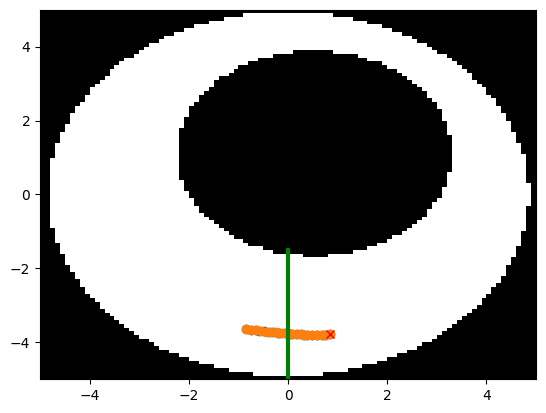

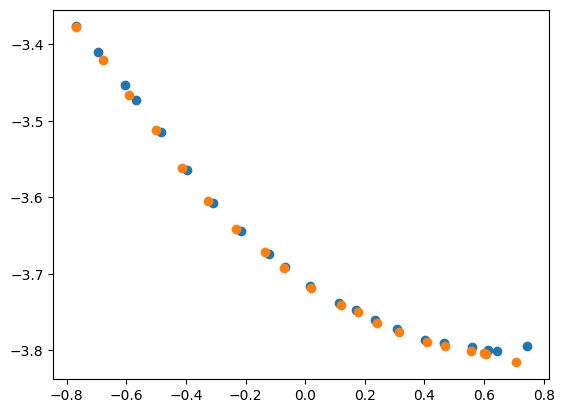

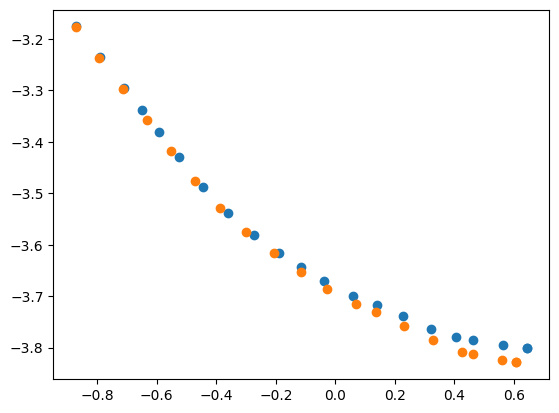

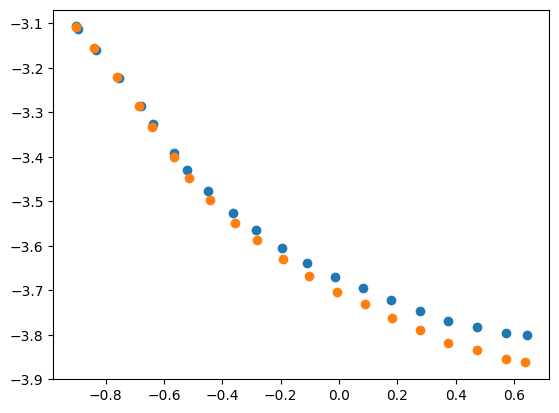

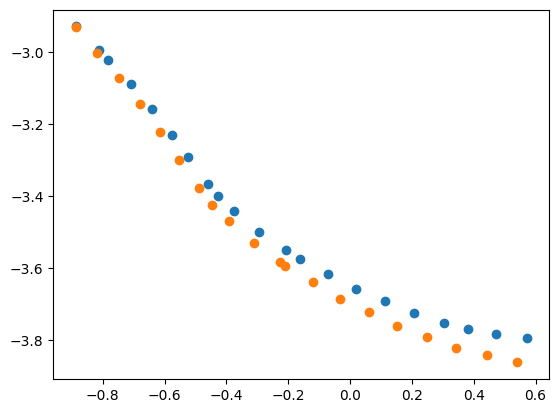

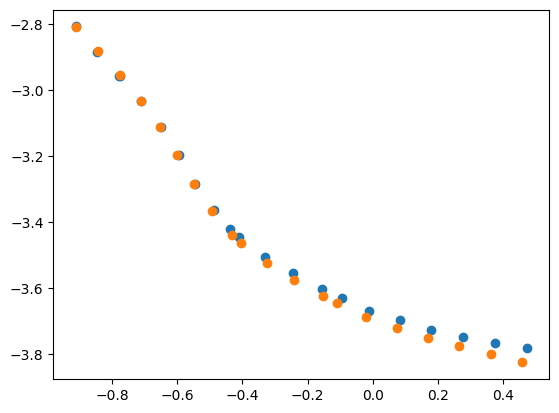

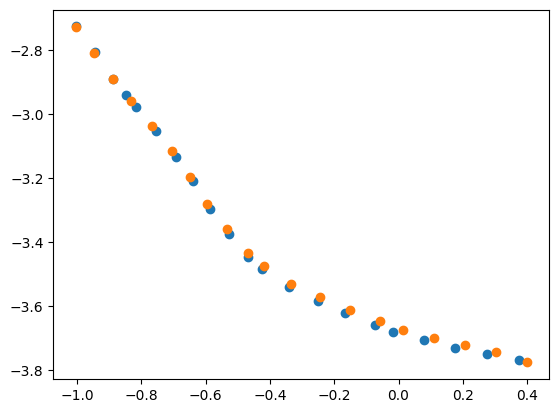

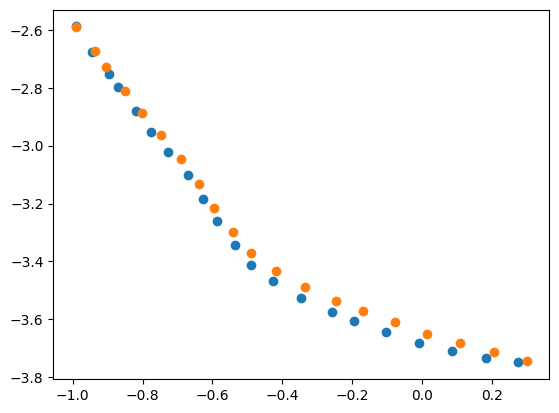

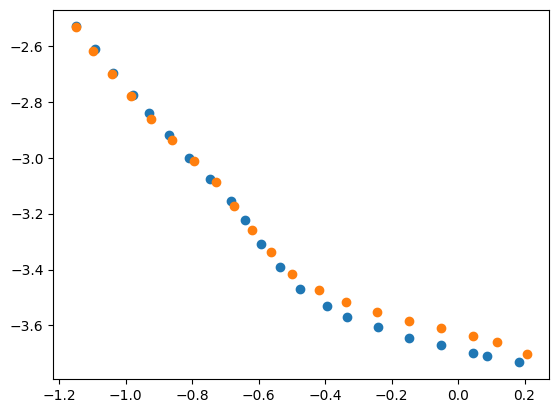

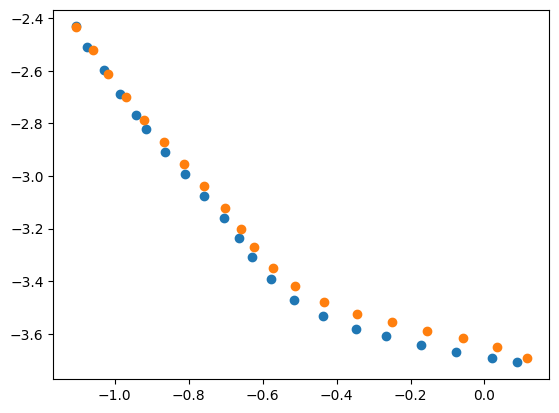

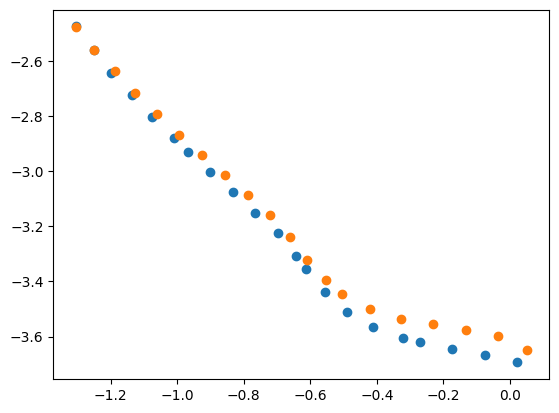

lap completed!
clockwise -> fwd lap completed


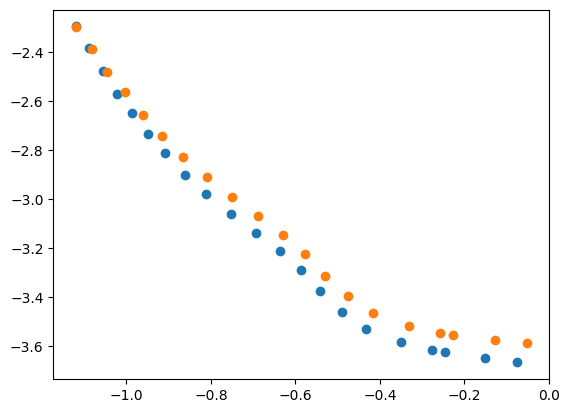

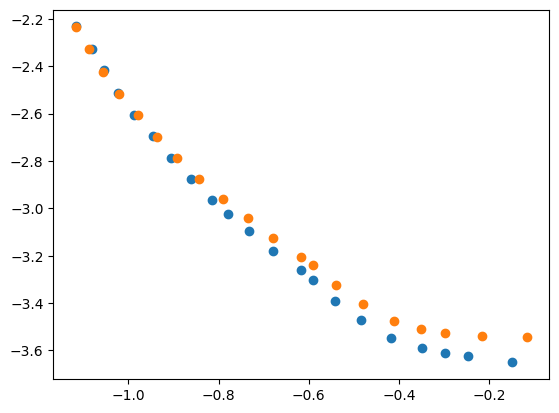

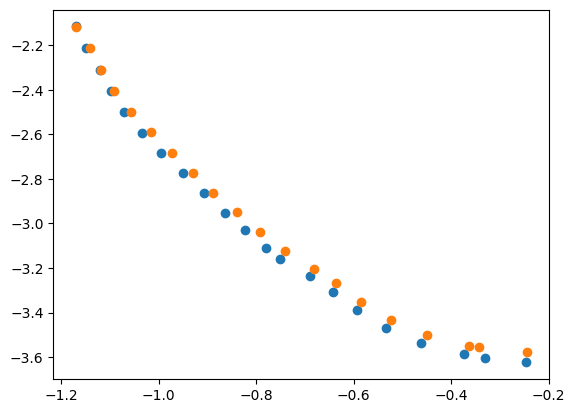

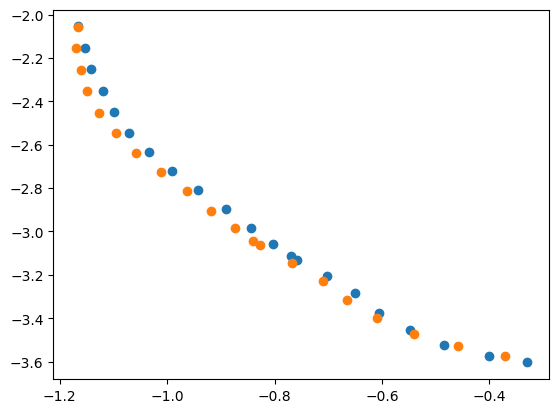

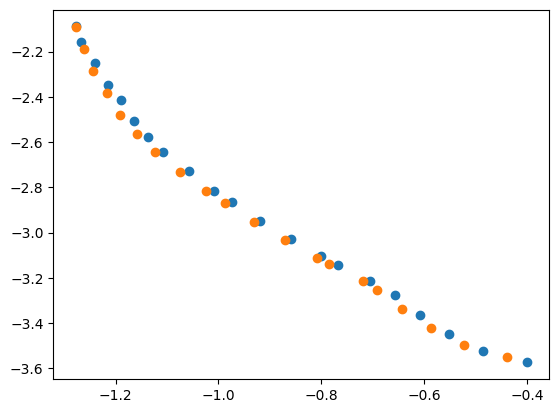

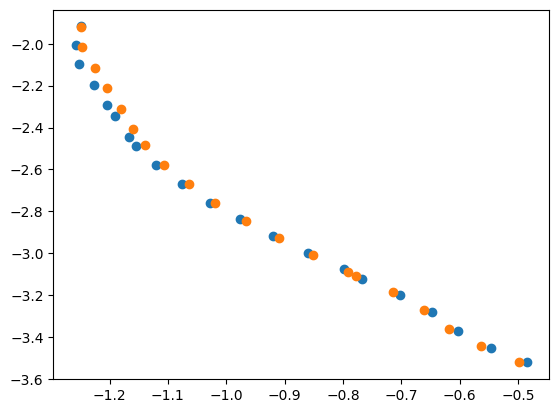

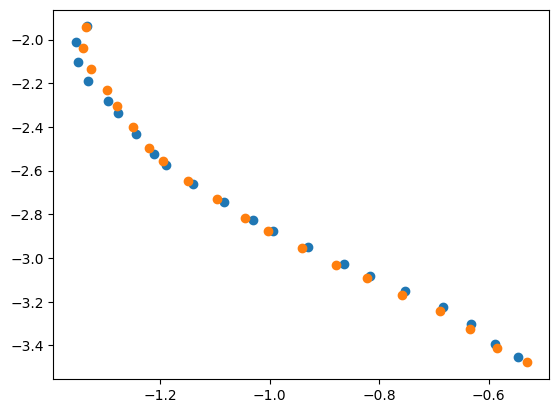

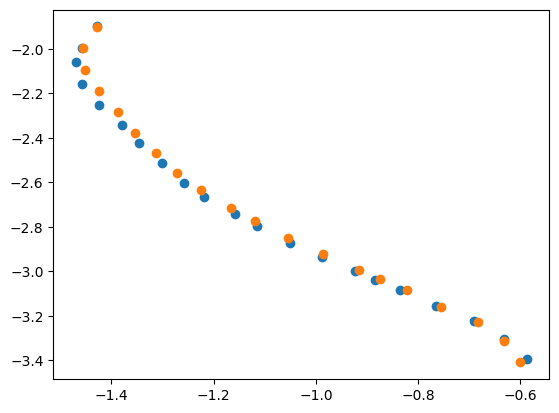

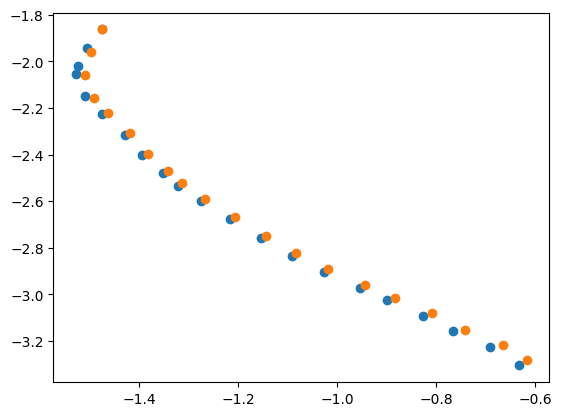

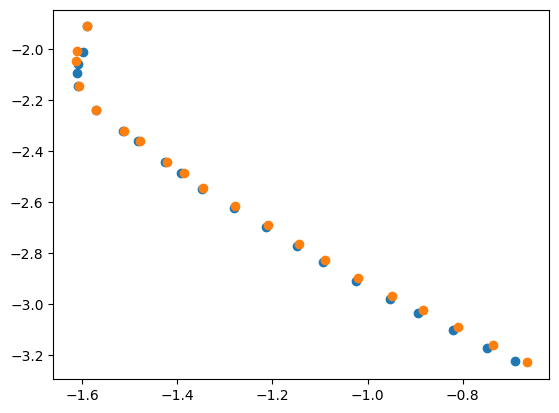

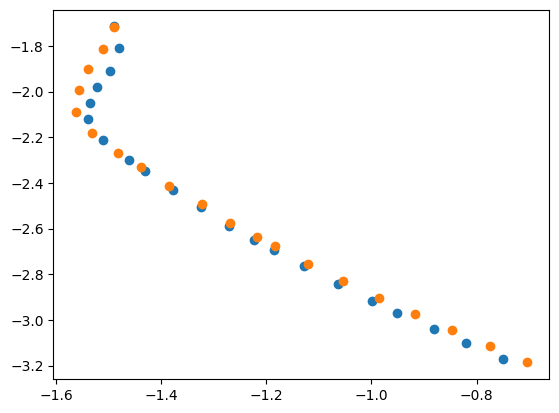

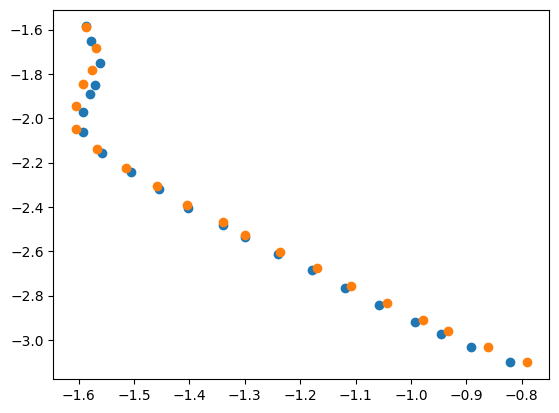

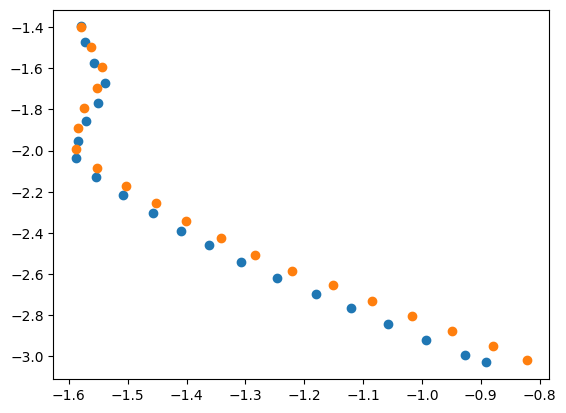

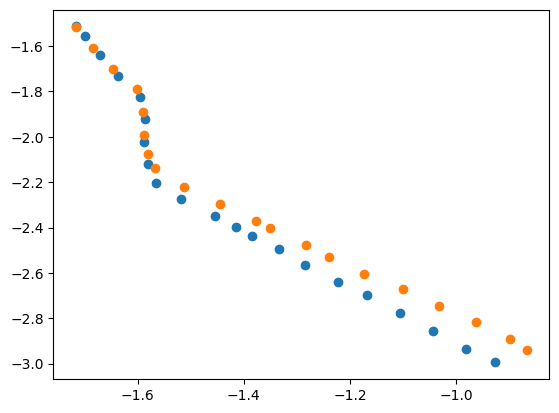

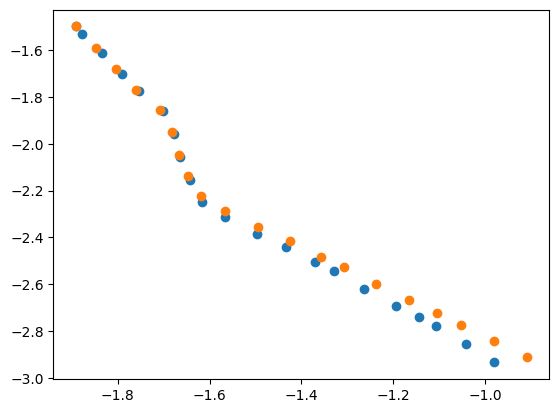

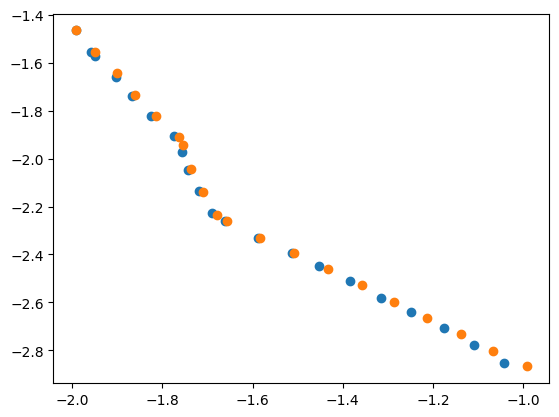

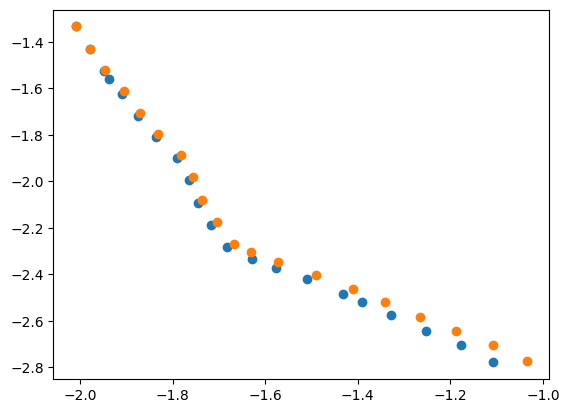

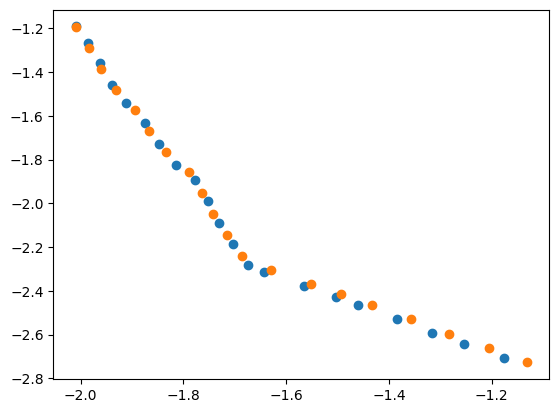

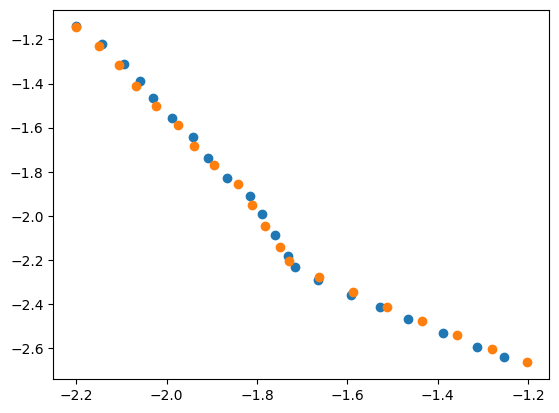

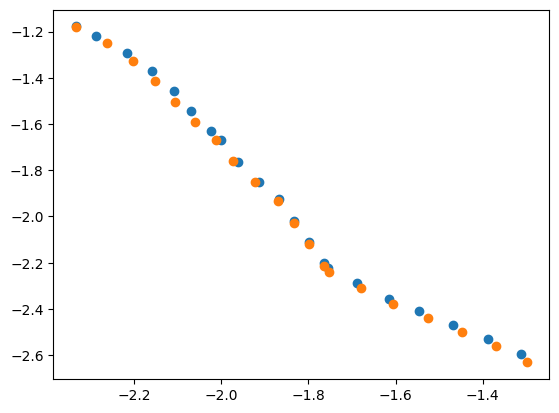

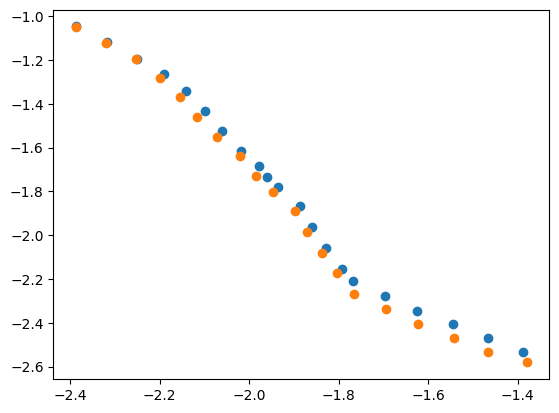

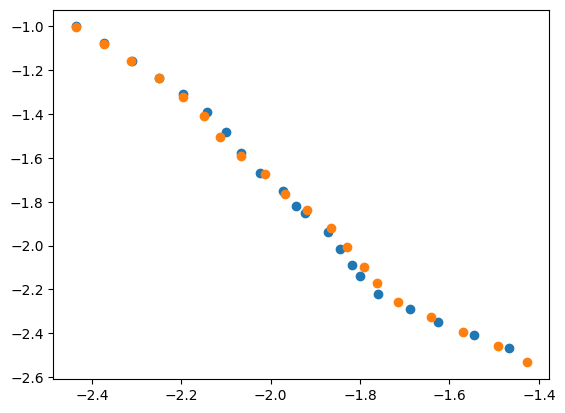

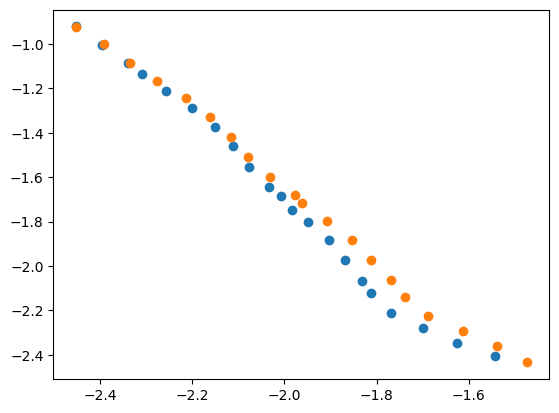

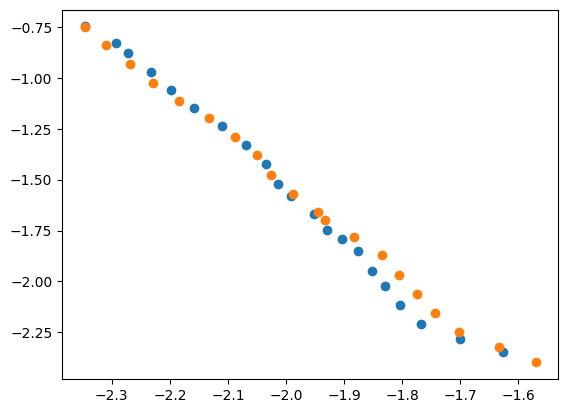

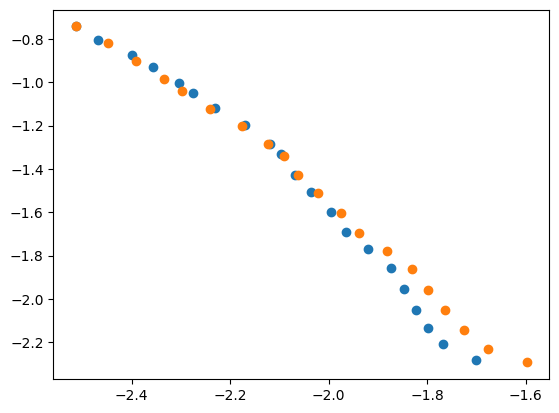

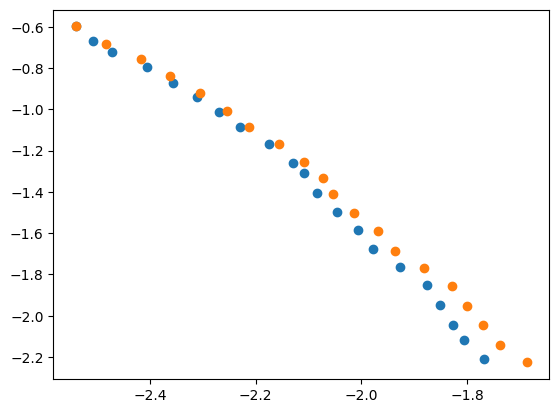

In [ ]:
# Create an instance of the mobile robot simulator we'll use this semester
env = gymnasium.make("gym_neu_racing/NEURacing-v0")

# Tell the simulator to directly provide the current state vector (no sensors yet)
env = StateFeedbackWrapper(env)
env.unwrapped.motion_model = NoisyUnicycle()
seed = 0
num_laps = 3
planner_class = TubeMPPIRacetrack
num_timesteps_used = run_planner_on_racetrack(
    env, planner_class=planner_class, seed=seed, num_laps=num_laps
)
print(f"num timesteps used: {num_timesteps_used}")